<a href="https://colab.research.google.com/github/Kravty/Applied-ML/blob/main/Optuna_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Optuna - what is it?

[Optuna](https://optuna.org) is a library that enables automatic hyperparameter tuning. Optuna is using something called Bayesian Optimisation underneath.

Bayesian Optimisation is used when we have some black box (for example function we don't know yet), which is costly (or time-consuming) to evaluate, and the goal is to find its optimal solution while being data efficient. By data efficient, I mean how many queries we ask the black box. An example application can be hyperparameter tuning of Deep Learning models when each training run is time-consuming and costly.

Using Bayesian Optimization for hyperparameters tuning has this advantage over grid search and random search that based on the provious run history the next attempts are more likely to be close to previous the best ones. In the case of grid search and random search, trials are independent thus trials history is not used. Let's take a look at the exemplary function where random search and Optuna were used to find the minimum.

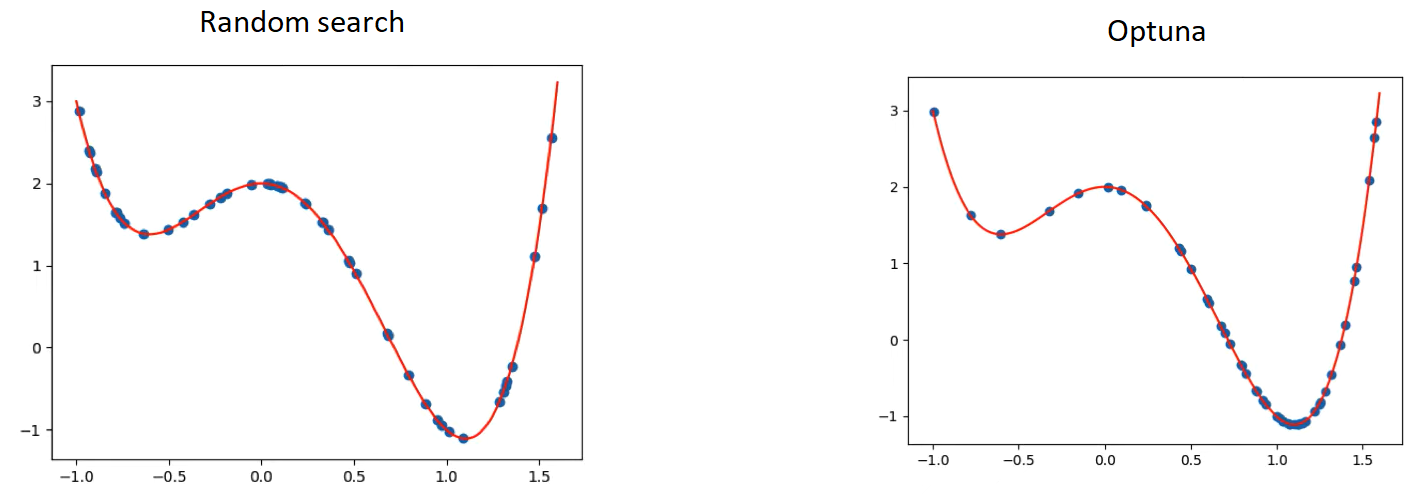
[Plots taken from Optuna tutorial](https://optuna.readthedocs.io/en/stable/tutorial/index.html)

Based on the plots, Optuna is sampling more frequently close to optimal values based on the history of previous trials. Moreover, Optuna has an additional pruning ability that prunes not promising trials in the early stage to not waste computational resources on the full run on bad hyperparameters choice.

### Optuna vs Grid Search

Let's check empirically how Optuna compares to Grid Search

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.4 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.trial import TrialState
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

Let's assume we want to find minimum value of one full cycle of sinus function:
<br>
$f(x)= sin(\frac{x}{2\pi})$
<br>
The expected result is -1.

Minimum value is -1.0


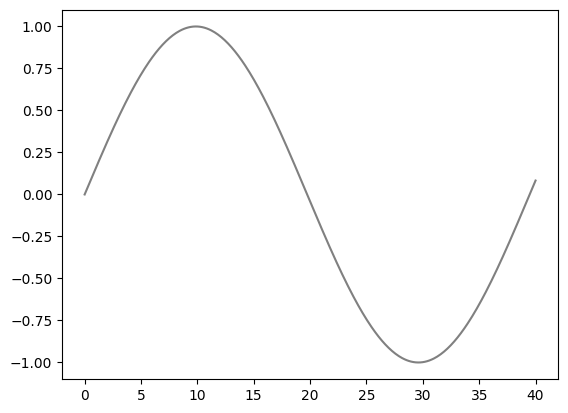

In [ ]:
function_range = 40
x = np.linspace(0, function_range, function_range * 10)
def f(x):
  return np.sin(x / (2 * np.pi))
y = f(x)
plt.plot(x, y, color='gray');
print('Minimum value is', round(y.min(), 4))

Let's start with grid search

In [ ]:
number_of_trials = 30
# take 30 evenly spaced samples (x) from given function range
grid_search_preds = np.linspace(0, function_range, number_of_trials)
# sort preds to plot it later
grid_search_preds = np.sort(grid_search_preds)
# calculate function values (f(x)) for this samples
grid_search_values = f(grid_search_preds)
# get minimal value as best prediction
grid_search_min_predicted_value = round(grid_search_values.min(), 4)
print('Minimum value of function for grid search', grid_search_min_predicted_value)
print(f'Error percentage: {round(100 * (-1 - grid_search_min_predicted_value), 2)}%')

Minimum value of function for grid search -0.9948
Error percentage: -0.52%


Grid search had 0.52% error. Now let's give a try Optuna

In [ ]:
# Optuna is black-box optimalizator thus we have to define its objective
def objective(trial):
    x = trial.suggest_uniform('x', 0, function_range)
    return f(x)

study = optuna.create_study(direction='minimize')
# again we are going to take 30 samples (x) but now not evenly spaced but values based on Bayesian Optimization
study.optimize(objective, n_trials=number_of_trials)

[I 2023-06-08 15:09:59,507] A new study created in memory with name: no-name-d4848657-04e8-4606-af5f-12eaf72b574d
<ipython-input-5-a7a1c45e7a2b>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  x = trial.suggest_uniform('x', 0, function_range)
[I 2023-06-08 15:09:59,514] Trial 0 finished with value: 0.15456440758477774 and parameters: {'x': 0.9750658344871876}. Best is trial 0 with value: 0.15456440758477774.
[I 2023-06-08 15:09:59,516] Trial 1 finished with value: -0.5901802225911273 and parameters: {'x': 35.511955367370916}. Best is trial 1 with value: -0.5901802225911273.
[I 2023-06-08 15:09:59,518] Trial 2 finished with value: -0.6240462090809309 and parameters: {'x': 35.24411431253498}. Best is trial 2 with value: -0.6240462090809309.
[I 2023-06-08 15:09:59,521] Trial 3 finished with value: 0.7626403979249414 and parameters: {'x': 5.4499435

In [ ]:
optuna_min_predicted_value = round(study.best_trial.value, 4)
print('Minimum value of function for Optuna', optuna_min_predicted_value)
print(f'Error percentage: {round(100 * (-1 - optuna_min_predicted_value), 2)}%')

Minimum value of function for Optuna -1.0
Error percentage: 0.0%


Optuna found value closer to minimum than grid search. Error for Optuna was 0.0% compared to 0.52% by grid search for such a simple function. Let's visualize all prediction of grid search and Optuna trials.

In [ ]:
optuna_preds = study.trials_dataframe()['params_x'].to_numpy()
# sort preds to plot it later
optuna_preds = np.sort(optuna_preds)
# calculate function values (f(x)) for this samples
optuna_values = f(optuna_preds)

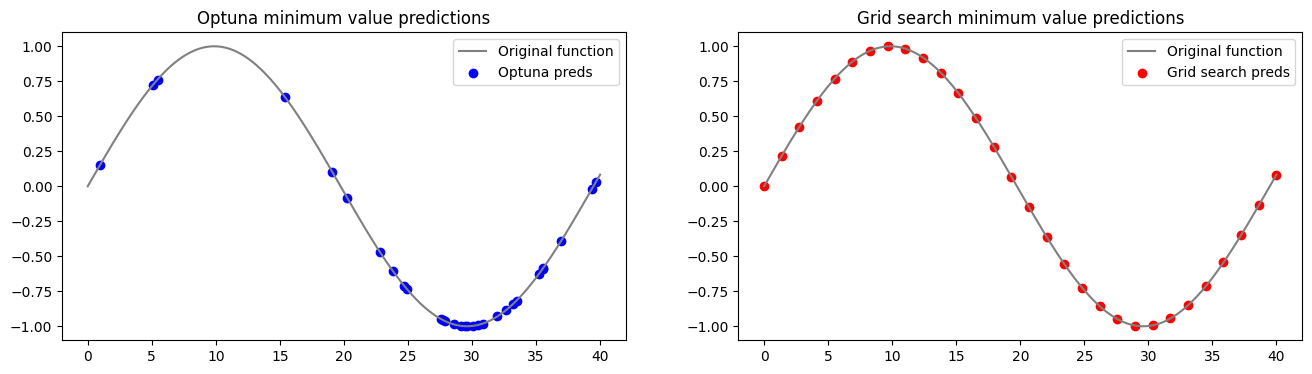

In [ ]:
# define grid and figure size
len_rows = 1
len_columns = 2
fig, axs = plt.subplots(len_rows, len_columns, figsize=(8 * len_columns, 4 * len_rows))
axs[0].plot(x, y, color='gray', label='Original function')
axs[0].scatter(optuna_preds, optuna_values, marker='o', color='blue', label='Optuna preds')
axs[0].set_title('Optuna minimum value predictions')
axs[0].legend();
axs[1].plot(x, y, color='gray', label='Original function')
axs[1].set_title('Grid search minimum value predictions')
axs[1].scatter(grid_search_preds, grid_search_values, marker="o", color='red', label='Grid search preds')
axs[1].legend();

### Other libraries for hyperparameter optimization

Optuna is not the only tool used for hyperparameter optimization. Although it is one of the most commonly used by professionals. Other popular libraries are:
* [Ray Tune](https://www.ray.io/ray-tune)
* [HYPEROPT](https://github.com/hyperopt/hyperopt)
* [Scikit-Optimize](https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html)

There are also AutoML solutions from cloud providers such as AWS, Azure, and Google Cloud. If you are interested in other solutions than Optuna and their comparison I encourage you to take a look at this [blog post](https://neptune.ai/blog/best-tools-for-model-tuning-and-hyperparameter-optimization).

## Model hyperparameter tunining by optuna

### Loading dataset

Let's use relatively small and simple dataset to conduct many experiments having in mind Colab computational limitations. I wil use [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) for simplicity.

In [ ]:
def get_dataset():
    train_transforms = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='.',
        train=True,
        transform=train_transforms,
        download=True)
    test_dataset = torchvision.datasets.CIFAR10(
        root='.',
        train=False,
        transform=transforms.ToTensor(),
        download=True)
    return train_dataset, test_dataset

### Define model

In [ ]:
class SimpleCNN(nn.Module):
  def __init__(self, output_classes):
    super(SimpleCNN, self).__init__()

    # Convolutional layers
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2)
    )

    # Dense layers
    self.d1 = nn.Linear(64 * 4 * 4 * 4, 256)
    self.d2 = nn.Linear(256, output_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.size(0), -1)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.d1(x))
    x = F.dropout(x, p=0.2)
    x = self.d2(x)
    return x

### Train and test functions

In [ ]:
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    losses = []
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        # use mixed precision to speed up training
        with torch.autocast(device_type='cuda'):
            outputs = model(X)
            loss = criterion(outputs, y)
            losses.append(loss.item())
            optimizer.zero_grad()  # Zero the gradients accumulated by PyTorch
            # Backward and optimize
            loss.backward()
            optimizer.step()

    # Taking mean value of previous losses as loss per epoch
    losses = np.mean(losses)

    return losses

In [ ]:
def test(model, criterion, test_loader, device):
    model.eval()
    losses = []
    preds, gt = [], []  # will be used for accuracy and confusion matrix

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            losses.append(loss.item())
            # save predictions and ground truths for evaluation
            softmax_outputs = torch.nn.functional.softmax(input=outputs, dim=1)
            softmax_vals, indices = softmax_outputs.max(1)
            y = y.detach().cpu().numpy()
            pred = indices.detach().cpu().numpy()
            if len(preds) == 0:
                preds.append(pred)
                gt.append(y)
            else:
                preds[0] = np.append(preds[0], pred, axis=0)
                gt[0] = np.append(gt[0], y, axis=0)

    preds = np.concatenate(np.array(preds), axis=0)
    gt = np.concatenate(np.array(gt), axis=0)
    # taking mean value of previous losses as loss per epoch
    losses = np.mean(losses)

    return losses, preds, gt

Normally and in this case it is possible to use the objective function as earlier. However, I would like to show you the alternative way by creating a Class instead of a function. It has the advantage that we can use some extra parameters. Moreover, we can initialize some objects once and use them in each trial instead of reinitializing them. It is particullary usefull to init some computationally expensive or time-consuming operations for example preparation of the custom dataset when the dataset is big.

In [ ]:
class Objective(object):
    def __init__(self, num_epochs, batch_size, model_checkpoint_path):
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.model_checkpoint_path = model_checkpoint_path
        # init best_val_metric with 0
        self.best_val_metric = 0
        # init dataset and data loaders
        self.train_dataset, self.test_dataset = get_dataset()
        self.train_loader = torch.utils.data.DataLoader(dataset=self.train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=self.test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=False)
        # instantiate the model
        self.model = SimpleCNN(output_classes=len(set(self.train_dataset.targets)))
        # define device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if self.device == torch.device("cuda"):
            cudnn.benchmark = True
        self.model.to(self.device)
        # it's multiclass classification so we are going to use Cross Entropy Loss
        self.criterion = torch.nn.CrossEntropyLoss().to(self.device)

    # use standard training loop with optuna in __call__ method
    def __call__(self, trial):
        # copy the model to train the model at the same starting point in each trial
        model = copy.deepcopy(self.model)
        # optuna parameterts
        optuna_params = {}
        lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])

        optuna_params['lr'] = lr
        optuna_params['optimizer_name'] = optimizer_name
        print(f'Optuna current parameters: {[(key, value) for key, value in optuna_params.items()]}')
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

        # set learning rate scheduler
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=int(self.num_epochs / 10), gamma=0.5)

        epoch_iterator = tqdm(range(self.num_epochs),
                              desc="Epoch X: train_loss=X, dev_loss=X, dev_acc=X",
                              bar_format="{l_bar}{r_bar}", dynamic_ncols=True,
                              disable=False)
        for epoch in epoch_iterator:
            train_loss = train(model, self.criterion, optimizer,
                               self.train_loader, self.device)
            test_loss, test_preds, test_gt = test(model, self.criterion,
                                                  self.test_loader, self.device)
            test_accuracy = (test_preds == test_gt).sum().item() / len(test_gt)

            epoch_iterator.set_description(
                f"Epoch {epoch + 1}: train_loss={train_loss:.5f}, test_loss={test_loss:.5f}, test_acc={test_accuracy:.3f}")

            # save checkpoint if accuracy is the best achieved so far
            if test_accuracy > self.best_val_metric:
                model_state_dict = model.state_dict()
                torch.save(
                    dict(
                        epoch=epoch + 1,
                        state_dict=model_state_dict,
                        optimizer_state_dict=optimizer.state_dict(),
                    ),
                    self.model_checkpoint_path)
                self.best_val_metric = test_accuracy

            # adjust learning rate
            scheduler.step()

            # optuna utils
            trial.report(test_accuracy, epoch)
            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        return test_accuracy

In [ ]:
NUM_EPOCHS = 50
BATCH_SIZE = 512
MODEL_CHECKPOINT_PATH = 'best_model.pth'
study = optuna.create_study(direction="maximize")
class_objective = Objective(num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                            model_checkpoint_path=MODEL_CHECKPOINT_PATH)
study.optimize(class_objective, n_trials=20, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("--> Optuna study statistics <--")
print("Number of finished trials: ", len(study.trials))
print("Number of pruned trials: ", len(pruned_trials))
print("Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("Value:", trial.value)

print("Params:")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

[I 2023-06-08 15:10:00,986] A new study created in memory with name: no-name-77b4d1bb-7391-4f7a-92ec-efda62740805


100%|██████████| 170498071/170498071 [00:13<00:00, 13021278.57it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

Optuna current parameters: [('lr', 0.00304135145969802), ('optimizer_name', 'Adam')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=1.72462, test_loss=1.55039, test_acc=0.476:   0%|| 0/50 [00:31<?, ?it/s]
Epoch 1: train_loss=1.72462, test_loss=1.55039, test_acc=0.476:   2%|| 1/50 [00:31<25:37, 31.37s/it]
Epoch 2: train_loss=1.32414, test_loss=1.45341, test_acc=0.529:   2%|| 1/50 [00:55<25:37, 31.37s/it]
Epoch 2: train_loss=1.32414, test_loss=1.45341, test_acc=0.529:   4%|| 2/50 [00:55<21:50, 27.30s/it]
Epoch 3: train_loss=1.14449, test_loss=1.06890, test_acc=0.627:   4%|| 2/50 [01:19<21:50, 27.30s/it]
Epoch 3: train_loss=1.14449, test_loss=1.06890, test_acc=0.627:   6%|| 3/50 [01:19<19:59, 25.51s/it]
Epoch 4: train_loss=1.05864, test_loss=1.07019, test_acc=0.628:   6%|| 3/50 [01:42<19:59, 25.51s/it]
Epoch 4: train_loss=1.05864, test_loss=1.07019, test_acc=0.628:   8%|| 4/50 [01:42<18:49, 24.56s/it]
Epoch 5: train_loss=0.98368, test_loss=1.00990, test_acc=0.641:   8%|| 4/50 [02:05<18:49, 24.56s/it]
Epoch 5: train_loss=0.9

[I 2023-06-08 15:29:51,938] Trial 0 finished with value: 0.8009 and parameters: {'lr': 0.00304135145969802, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.8009.
Optuna current parameters: [('lr', 0.001666606648972633), ('optimizer_name', 'SGD')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=2.27753, test_loss=2.12681, test_acc=0.222:   0%|| 0/50 [00:22<?, ?it/s]
Epoch 1: train_loss=2.27753, test_loss=2.12681, test_acc=0.222:   2%|| 1/50 [00:22<18:37, 22.81s/it]
Epoch 2: train_loss=2.07178, test_loss=1.96038, test_acc=0.284:   2%|| 1/50 [00:45<18:37, 22.81s/it]
Epoch 2: train_loss=2.07178, test_loss=1.96038, test_acc=0.284:   4%|| 2/50 [00:45<18:19, 22.90s/it]
Epoch 3: train_loss=1.95445, test_loss=1.85983, test_acc=0.321:   4%|| 2/50 [01:09<18:19, 22.90s/it]
Epoch 3: train_loss=1.95445, test_loss=1.85983, test_acc=0.321:   6%|| 3/50 [01:09<18:04, 23.08s/it]
Epoch 4: train_loss=1.87982, test_loss=1.78603, test_acc=0.350:   6%|| 3/50 [01:32<18:04, 23.08s/it]
Epoch 4: train_loss=1.87982, test_loss=1.78603, test_acc=0.350:   8%|| 4/50 [01:32<17:42, 23.10s/it]
Epoch 5: train_loss=1.82943, test_loss=1.73335, test_acc=0.368:   8%|| 4/50 [01:55<17:42, 23.10s/it]
Epoch 5: train_loss=1.8

[I 2023-06-08 15:49:11,152] Trial 1 finished with value: 0.4322 and parameters: {'lr': 0.001666606648972633, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.8009.
Optuna current parameters: [('lr', 0.00017468377177411184), ('optimizer_name', 'AdamW')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=1.75394, test_loss=1.43643, test_acc=0.480:   0%|| 0/50 [00:23<?, ?it/s]
Epoch 1: train_loss=1.75394, test_loss=1.43643, test_acc=0.480:   2%|| 1/50 [00:23<18:50, 23.08s/it]
Epoch 2: train_loss=1.43152, test_loss=1.24675, test_acc=0.553:   2%|| 1/50 [00:46<18:50, 23.08s/it]
Epoch 2: train_loss=1.43152, test_loss=1.24675, test_acc=0.553:   4%|| 2/50 [00:46<18:34, 23.22s/it]
Epoch 3: train_loss=1.28388, test_loss=1.13160, test_acc=0.595:   4%|| 2/50 [01:08<18:34, 23.22s/it]
Epoch 3: train_loss=1.28388, test_loss=1.13160, test_acc=0.595:   6%|| 3/50 [01:08<17:57, 22.93s/it]
Epoch 4: train_loss=1.19051, test_loss=1.04788, test_acc=0.630:   6%|| 3/50 [01:32<17:57, 22.93s/it]
Epoch 4: train_loss=1.19051, test_loss=1.04788, test_acc=0.630:   8%|| 4/50 [01:32<17:36, 22.97s/it]
Epoch 5: train_loss=1.11888, test_loss=1.02110, test_acc=0.642:   8%|| 4/50 [01:55<17:36, 22.97s/it]
Epoch 5: train_loss=1.1

[I 2023-06-08 16:08:28,243] Trial 2 finished with value: 0.7148 and parameters: {'lr': 0.00017468377177411184, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.8009.
Optuna current parameters: [('lr', 0.00026545625449584694), ('optimizer_name', 'Adam')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=1.68287, test_loss=1.38398, test_acc=0.501:   0%|| 0/50 [00:23<?, ?it/s]
Epoch 1: train_loss=1.68287, test_loss=1.38398, test_acc=0.501:   2%|| 1/50 [00:23<18:58, 23.24s/it]
Epoch 2: train_loss=1.35923, test_loss=1.20192, test_acc=0.565:   2%|| 1/50 [00:46<18:58, 23.24s/it]
Epoch 2: train_loss=1.35923, test_loss=1.20192, test_acc=0.565:   4%|| 2/50 [00:46<18:40, 23.35s/it]
Epoch 3: train_loss=1.20967, test_loss=1.07285, test_acc=0.621:   4%|| 2/50 [01:09<18:40, 23.35s/it]
Epoch 3: train_loss=1.20967, test_loss=1.07285, test_acc=0.621:   6%|| 3/50 [01:09<18:12, 23.23s/it]
Epoch 4: train_loss=1.11334, test_loss=0.99427, test_acc=0.650:   6%|| 3/50 [01:33<18:12, 23.23s/it]
Epoch 4: train_loss=1.11334, test_loss=0.99427, test_acc=0.650:   8%|| 4/50 [01:33<17:50, 23.27s/it]
Epoch 5: train_loss=1.04604, test_loss=0.94893, test_acc=0.666:   8%|| 4/50 [01:55<17:50, 23.27s/it]
Epoch 5: train_loss=1.0

[I 2023-06-08 16:27:47,738] Trial 3 finished with value: 0.7422 and parameters: {'lr': 0.00026545625449584694, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.8009.
Optuna current parameters: [('lr', 0.0022279076272493843), ('optimizer_name', 'AdamW')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=1.64742, test_loss=1.39278, test_acc=0.507:   0%|| 0/50 [00:23<?, ?it/s]
Epoch 1: train_loss=1.64742, test_loss=1.39278, test_acc=0.507:   2%|| 1/50 [00:23<18:57, 23.21s/it]
Epoch 2: train_loss=1.28248, test_loss=1.18104, test_acc=0.588:   2%|| 1/50 [00:46<18:57, 23.21s/it]
Epoch 2: train_loss=1.28248, test_loss=1.18104, test_acc=0.588:   4%|| 2/50 [00:46<18:34, 23.21s/it]
Epoch 3: train_loss=1.12178, test_loss=1.09291, test_acc=0.613:   4%|| 2/50 [01:09<18:34, 23.21s/it]
Epoch 3: train_loss=1.12178, test_loss=1.09291, test_acc=0.613:   6%|| 3/50 [01:09<18:08, 23.17s/it]
Epoch 4: train_loss=1.01896, test_loss=1.00971, test_acc=0.651:   6%|| 3/50 [01:32<18:08, 23.17s/it]
Epoch 4: train_loss=1.01896, test_loss=1.00971, test_acc=0.651:   8%|| 4/50 [01:32<17:49, 23.26s/it]
Epoch 5: train_loss=0.96392, test_loss=0.99738, test_acc=0.654:   8%|| 4/50 [01:56<17:49, 23.26s/it]
Epoch 5: train_loss=0.9

[I 2023-06-08 16:47:05,870] Trial 4 finished with value: 0.7973 and parameters: {'lr': 0.0022279076272493843, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.8009.
Optuna current parameters: [('lr', 0.00836294951482303), ('optimizer_name', 'Adam')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=2.27128, test_loss=2.01771, test_acc=0.329:   0%|| 0/50 [00:22<?, ?it/s]


[I 2023-06-08 16:47:28,596] Trial 5 pruned. 
Optuna current parameters: [('lr', 0.0009051970994668778), ('optimizer_name', 'AdamW')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=1.64801, test_loss=1.29473, test_acc=0.538:   0%|| 0/50 [00:23<?, ?it/s]
Epoch 1: train_loss=1.64801, test_loss=1.29473, test_acc=0.538:   2%|| 1/50 [00:23<19:01, 23.30s/it]
Epoch 2: train_loss=1.24440, test_loss=1.13933, test_acc=0.586:   2%|| 1/50 [00:46<19:01, 23.30s/it]
Epoch 2: train_loss=1.24440, test_loss=1.13933, test_acc=0.586:   4%|| 2/50 [00:46<18:37, 23.28s/it]
Epoch 3: train_loss=1.07833, test_loss=0.98049, test_acc=0.651:   4%|| 2/50 [01:09<18:37, 23.28s/it]
Epoch 3: train_loss=1.07833, test_loss=0.98049, test_acc=0.651:   6%|| 3/50 [01:09<18:10, 23.21s/it]
Epoch 4: train_loss=0.98836, test_loss=0.88903, test_acc=0.685:   6%|| 3/50 [01:32<18:10, 23.21s/it]
Epoch 4: train_loss=0.98836, test_loss=0.88903, test_acc=0.685:   8%|| 4/50 [01:32<17:44, 23.14s/it]
Epoch 5: train_loss=0.91201, test_loss=0.83596, test_acc=0.701:   8%|| 4/50 [01:56<17:44, 23.14s/it]
Epoch 5: train_loss=0.9

[I 2023-06-08 17:06:46,792] Trial 6 finished with value: 0.7862 and parameters: {'lr': 0.0009051970994668778, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.8009.
Optuna current parameters: [('lr', 0.006864224659847781), ('optimizer_name', 'AdamW')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=2.14269, test_loss=3.78691, test_acc=0.197:   0%|| 0/50 [00:22<?, ?it/s]


[I 2023-06-08 17:07:09,554] Trial 7 pruned. 
Optuna current parameters: [('lr', 0.005094739971190146), ('optimizer_name', 'SGD')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=2.10410, test_loss=1.87528, test_acc=0.313:   0%|| 0/50 [00:22<?, ?it/s]


[I 2023-06-08 17:07:31,956] Trial 8 pruned. 
Optuna current parameters: [('lr', 0.0018935616687416707), ('optimizer_name', 'SGD')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=2.26125, test_loss=2.09228, test_acc=0.232:   0%|| 0/50 [00:22<?, ?it/s]


[I 2023-06-08 17:07:54,858] Trial 9 pruned. 
Optuna current parameters: [('lr', 0.000548541323432575), ('optimizer_name', 'Adam')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=1.60085, test_loss=1.30097, test_acc=0.536:   0%|| 0/50 [00:22<?, ?it/s]
Epoch 1: train_loss=1.60085, test_loss=1.30097, test_acc=0.536:   2%|| 1/50 [00:22<18:45, 22.96s/it]
Epoch 2: train_loss=1.25018, test_loss=1.05952, test_acc=0.621:   2%|| 1/50 [00:45<18:45, 22.96s/it]
Epoch 2: train_loss=1.25018, test_loss=1.05952, test_acc=0.621:   4%|| 2/50 [00:45<18:22, 22.97s/it]
Epoch 3: train_loss=1.10061, test_loss=1.06572, test_acc=0.630:   4%|| 2/50 [01:08<18:22, 22.97s/it]
Epoch 3: train_loss=1.10061, test_loss=1.06572, test_acc=0.630:   6%|| 3/50 [01:08<17:55, 22.89s/it]
Epoch 4: train_loss=1.01540, test_loss=0.91775, test_acc=0.680:   6%|| 3/50 [01:31<17:55, 22.89s/it]
Epoch 4: train_loss=1.01540, test_loss=0.91775, test_acc=0.680:   8%|| 4/50 [01:31<17:35, 22.94s/it]
Epoch 5: train_loss=0.94031, test_loss=0.87625, test_acc=0.691:   8%|| 4/50 [01:54<17:35, 22.94s/it]
Epoch 5: train_loss=0.9

[I 2023-06-08 17:26:54,977] Trial 10 finished with value: 0.7795 and parameters: {'lr': 0.000548541323432575, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.8009.
Optuna current parameters: [('lr', 0.0029385778099368853), ('optimizer_name', 'Adam')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=1.76448, test_loss=1.53824, test_acc=0.454:   0%|| 0/50 [00:22<?, ?it/s]


[I 2023-06-08 17:27:17,732] Trial 11 pruned. 
Optuna current parameters: [('lr', 0.003238651582345475), ('optimizer_name', 'AdamW')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=1.71587, test_loss=1.42998, test_acc=0.494:   0%|| 0/50 [00:23<?, ?it/s]


[I 2023-06-08 17:27:41,584] Trial 12 pruned. 
Optuna current parameters: [('lr', 0.0011532590493592385), ('optimizer_name', 'Adam')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=1.65020, test_loss=1.47210, test_acc=0.499:   0%|| 0/50 [00:22<?, ?it/s]


[I 2023-06-08 17:28:04,392] Trial 13 pruned. 
Optuna current parameters: [('lr', 0.004021592396297223), ('optimizer_name', 'AdamW')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=1.99889, test_loss=1.66363, test_acc=0.414:   0%|| 0/50 [00:22<?, ?it/s]


[I 2023-06-08 17:28:26,988] Trial 14 pruned. 
Optuna current parameters: [('lr', 0.0022085771405188797), ('optimizer_name', 'Adam')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=1.68765, test_loss=1.43857, test_acc=0.492:   0%|| 0/50 [00:22<?, ?it/s]


[I 2023-06-08 17:28:49,584] Trial 15 pruned. 
Optuna current parameters: [('lr', 0.005087237273563544), ('optimizer_name', 'AdamW')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=1.93968, test_loss=1.75966, test_acc=0.398:   0%|| 0/50 [00:22<?, ?it/s]


[I 2023-06-08 17:29:12,596] Trial 16 pruned. 
Optuna current parameters: [('lr', 0.009534238046659886), ('optimizer_name', 'Adam')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=2.25680, test_loss=1.82608, test_acc=0.361:   0%|| 0/50 [00:22<?, ?it/s]


[I 2023-06-08 17:29:35,423] Trial 17 pruned. 
Optuna current parameters: [('lr', 0.002852735331637197), ('optimizer_name', 'AdamW')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=1.80798, test_loss=1.50777, test_acc=0.458:   0%|| 0/50 [00:22<?, ?it/s]


[I 2023-06-08 17:29:58,381] Trial 18 pruned. 
Optuna current parameters: [('lr', 0.0012725449417487144), ('optimizer_name', 'SGD')]



Epoch X: train_loss=X, dev_loss=X, dev_acc=X:   0%|| 0/50 [00:00<?, ?it/s]
Epoch 1: train_loss=2.30269, test_loss=2.17538, test_acc=0.202:   0%|| 0/50 [00:22<?, ?it/s]


[I 2023-06-08 17:30:21,077] Trial 19 pruned. 
--> Optuna study statistics <--
Number of finished trials:  20
Number of pruned trials:  13
Number of complete trials:  7
Best trial:
Value: 0.8009
Params:
lr: 0.00304135145969802
optimizer: Adam
